<span style="font-family:Chandas;font-size: 220%;color:#1155cc"> Najprostrzy system rekomendacji dla CallCenter 



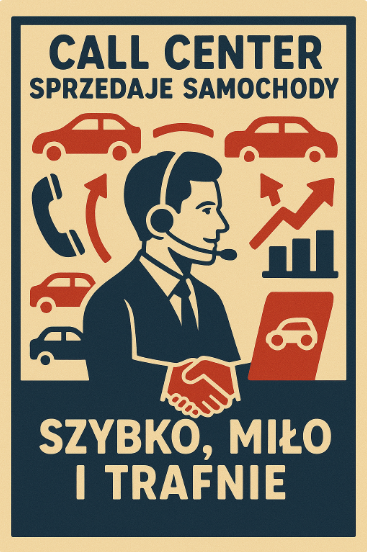

In [1]:
import pandas as pd
import numpy as np
import warnings   

warnings.filterwarnings("ignore")

### Baza 1000 klientów call center

In [2]:
df = pd.read_csv("synthetic_customers_1000.csv")
df.head(4)

,customer_id,gender,age,education_level,business_type,monthly_income_pln,dependents,dwelling_type,residence_area,distance_to_city_km,...,previous_vehicle_model,previous_trim,previous_financing,previous_insurance,previous_purchase_price,previous_monthly_rate,previous_vehicle_age_at_purchase,current_budget_monthly_max,dti_limit,updated_at
0,1,M,24,master,unemployed,31843,2,apartment,urban,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8703.0,0.37,2025-09-18 05:56:25.242966
1,2,M,62,master,public_sector,40000,0,house,rural,19,...,A2 Micro,base,cash,OC_only,76469.0,0.00,0.0,11801.0,0.35,2025-10-29 05:56:25.242966
2,3,M,56,bachelor,retired,40000,1,house,rural,48,...,F3 Edge,base,lease_36,OC_AC,92528.0,82.14,3.0,11881.0,0.30,2025-08-16 05:56:25.242966
3,4,F,44,phd,student,40000,2,house,urban,0,...,B1 Compact,premium,lease_36,OC_AC,89614.0,83.94,2.0,9927.0,0.29,2025-10-29 05:56:25.242966


In [3]:
df.shape

(1000, 31)

- <div class="alert-info"; span style="font-size: 120% "> Kolumna has_history </div> True oznacza, że uzupełnione są m.in. monthly_km, previous_vehicle_*, previous_financing, previous_insurance, previous_purchase_price, previous_monthly_rate.

- <div class="alert-info"; span style="font-size: 120% "> distance_to_city_km </div> = 0 dla residence_area = "urban", a dla rural losowana z przewagą mniejszych dystansów.

- <div class="alert-info"; span style="font-size: 120% ">road_quality_1to5 </div>zależy od residence_area i distance_to_city_km.

- Budżet miesięczny (current_budget_monthly_max) i dti_limit wynikają z dochodu, profilu ryzyka i „zdroworozsądkowych” reguł.

<span style="font-size: 180%; background: yellow; color: #1155cc"> Celem jest mieć sensowną listę propozycji dla konsultanta bez trenowania skomplikowanych modeli.

#### 1. FILTR MOŻLIWOŚCI FINANSOWYCH
odrzucamy samochody, których szacowana rata przekracza możliwości finansowe klienta.

#### 2. SZUKAMY PO POPULARNOŚCI
- z tych opcji, rat, które klient da radę sfinansować wybieramy najbardziej popularne modele
- sortujemy po smoothed popularity policzonej na historii zakupów dla podobnych klientów, ten sam bucket dochodu i nie klaster.

## sprawdzenie jaki jest rozkład dochodów

In [4]:
df['current_budget_monthly_max'].head(4)

0     8703.0
1    11801.0
2    11881.0
3     9927.0
Name: current_budget_monthly_max, dtype: float64

In [5]:
df['klasy_dochodu'] = pd.qcut(df['current_budget_monthly_max'],6)

### 6 równolicznych klas wg current_budget_monthly_max

In [6]:
df['klasy_dochodu'].value_counts()

klasy_dochodu
(2673.999, 7104.0]    167
(7104.0, 8802.0]      167
(9996.5, 10842.0]     167
(11741.5, 13984.0]    167
(8802.0, 9996.5]      166
(10842.0, 11741.5]    166
Name: count, dtype: int64

qcut (kwantyle): równe liczności → mniej ryzyka, że jakiś bucket będzie pusty.

Progi są zmienne zależnie od czasu 
Gdyby zastosować sztywne progi lepsza interpretowalność biznesowa, ale liczności mogą być bardzo nierówne.
celem jest czysta „zdolność” pod ratę, 

<div class="alert-info"; span style="font-size: 180% "> krok 1: PIERWSZY FILTR REKOMENDACJI liczymy prosty limit raty (hard cap) na podstawie 6 klas dochodu</div>

to pierwszy filtr w systemie rekomendacji: zdarzenia w których rata przekracza typową zdolność dla klasy dochodu klienta. Klient nigdy nie zobaczy ofert poza swoim zasięgiem finansowym.

### affordability_cap_pln to mediana przedziału klasy dochodu

In [7]:
np.median([7104.0, 8802.0])

np.float64(7953.0)

In [8]:
df["affordability_cap_pln"] = df["klasy_dochodu"].apply(lambda x: (x.left + x.right)/2)

In [9]:
df[["customer_id","klasy_dochodu","current_budget_monthly_max","affordability_cap_pln"]].head()

,customer_id,klasy_dochodu,current_budget_monthly_max,affordability_cap_pln
0,1,"(7104.0, 8802.0]",8703.0,7953.00
1,2,"(11741.5, 13984.0]",11801.0,12862.75
2,3,"(11741.5, 13984.0]",11881.0,12862.75
3,4,"(8802.0, 9996.5]",9927.0,9399.25
4,5,"(8802.0, 9996.5]",9301.0,9399.25


### Baza danych pojazdów oferowanych do sprzedaży 336 samochodów

In [10]:
items_df =pd.read_csv("items_df.csv")

print(items_df.shape)
items_df.head(4)

(336, 8)


,Unnamed: 0,item_id,segment,model,trim,financing,price_est_pln,monthly_rate_est
0,0,1,city,A1 CityGo,base,cash,62500.0,0.00
1,1,2,city,A1 CityGo,base,lease_36,62500.0,53.82
2,2,3,city,A1 CityGo,base,lease_48,62500.0,39.06
3,3,4,city,A1 CityGo,base,loan_60,62500.0,35.42


<div class="alert-info"; span style="font-size: 180% "> Krok 2: interakcje z historii -> połączenie z katalogiem (items_df)


### Jakie są proporcje klientów z historią i baz historii zakupowej?

<Axes: title={'center': 'z historią'}, ylabel='count'>

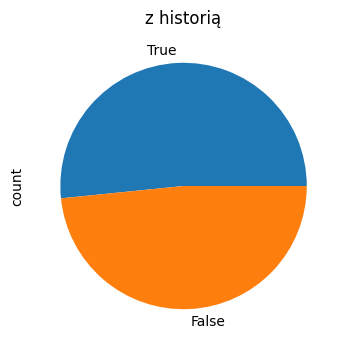

In [11]:
df["has_history"].value_counts().plot(kind = 'pie', figsize = (4,4), title='z historią')

In [12]:
interactions = (
    df.loc[df["has_history"], [
        "customer_id", "klasy_dochodu",
        "previous_vehicle_segment", "previous_vehicle_model",
        "previous_trim", "previous_financing",
        "previous_monthly_rate"]])

In [13]:
interactions.head(4)

,customer_id,klasy_dochodu,previous_vehicle_segment,previous_vehicle_model,previous_trim,previous_financing,previous_monthly_rate
1,2,"(11741.5, 13984.0]",city,A2 Micro,base,cash,0.00
2,3,"(11741.5, 13984.0]",crossover,F3 Edge,base,lease_36,82.14
3,4,"(8802.0, 9996.5]",compact,B1 Compact,premium,lease_36,83.94
4,5,"(8802.0, 9996.5]",suv,E3 Adventure,tech,lease_48,70.55


### ilu jest klientów z historią w klasach dochodów - mamy nierówniwagę?

In [15]:
kot=df.pivot_table(index=['klasy_dochodu'],
               columns = ["has_history"],
               values=['previous_vehicle_segment'],
               aggfunc='count').reset_index()
kot

klasy_dochodu previous_vehicle_segment     
has_history                                        False True
0            (2673.999, 7104.0]                        0   89
1              (7104.0, 8802.0]                        0   77
2              (8802.0, 9996.5]                        0   94
3             (9996.5, 10842.0]                        0   86
4            (10842.0, 11741.5]                        0   83
5            (11741.5, 13984.0]                        0   87

jest ok, rozrzucone dobrze w danych po dochodach

In [16]:
interactions = interactions.rename(columns={
        "previous_vehicle_segment": "segment",
        "previous_vehicle_model":   "model",
        "previous_trim":            "trim",
        "previous_financing":       "financing",
        "previous_monthly_rate":    "monthly_rate_pln"
    })

In [17]:
print(interactions.columns.tolist()) 

['customer_id', 'klasy_dochodu', 'segment', 'model', 'trim', 'financing', 'monthly_rate_pln']


In [18]:
df.columns

Index(['customer_id', 'gender', 'age', 'education_level', 'business_type',
       'monthly_income_pln', 'dependents', 'dwelling_type', 'residence_area',
       'distance_to_city_km', 'road_quality_1to5', 'wealth_estimate_pln',
       'credit_score_300_850', 'marital_status', 'preferred_contact',
       'risk_profile', 'owns_garage', 'has_children', 'has_history',
       'monthly_km', 'previous_vehicle_segment', 'previous_vehicle_model',
       'previous_trim', 'previous_financing', 'previous_insurance',
       'previous_purchase_price', 'previous_monthly_rate',
       'previous_vehicle_age_at_purchase', 'current_budget_monthly_max',
       'dti_limit', 'updated_at', 'klasy_dochodu', 'affordability_cap_pln'],
      dtype='object')

<div class="alert-info"; span style="font-size: 180% "> Krok 3: Łączenie z katalogiem ofert, aby dostać item_id </div>

In [19]:
interactions = interactions.merge(
    items_df[["item_id", "segment", "model", "trim", "financing"]],
    on=["segment", "model", "trim", "financing"],
    how="inner",
    validate="m:1"   # aby nie było duplikatów wiele->jeden jest jeden
)

To jest INNER JOIN (jak w SQL) między interactions a wycinkiem items_df.

Co się dzieje krok po kroku:

- Z items_df bierzesz tylko kolumny: ["item_id","segment","model","trim","financing"].
- Łączysz z interactions po kluczach ["segment","model","trim","financing"].
- how="inner" ⇒ zostają wyłącznie te wiersze z interactions, które mają dopasowanie w items_df (reszta wypada).

Do wyniku dopisywana jest kolumna item_id (oraz ewentualnie inne współdzielone kolumny z sufiksami).

Praktyczne uwagi:

Jeśli w items_df są duplikaty tych kluczy, wiersze w interactions mogą się mnożyć (iloczyn kartezjański).
Aby się zabezpieczyć:  validate="m:1"   # oczekujesz wiele->jeden

<div class="alert-info"; span style="font-size: 180% "> Krok 4: popularność per klasy_dochodu + smoothing</div>

Cel: label=1 oznacza pozytywną interakcję w historii; na tej bazie, jak często dany item był wybierany w danej klasie dochodu (p_local).

In [20]:
interactions.columns

Index(['customer_id', 'klasy_dochodu', 'segment', 'model', 'trim', 'financing',
       'monthly_rate_pln', 'item_id'],
      dtype='object')

### tworze sobie kolumne label=1

In [21]:
interactions["label"] = 1

ile wszystkich transakcji w grupach?

In [22]:
bucket_total = interactions.groupby("klasy_dochodu")["label"].sum().reset_index()
bucket_total = bucket_total.rename(columns = {"label": "bucket_total"})
bucket_total.head(3)

,klasy_dochodu,bucket_total
0,"(2673.999, 7104.0]",89
1,"(7104.0, 8802.0]",77
2,"(8802.0, 9996.5]",94


In [23]:
item_bucket  = interactions.groupby(["klasy_dochodu","item_id"])["label"].sum().reset_index()
item_bucket = item_bucket.rename(columns = {"label": "item_bucket_total"})
item_bucket

,klasy_dochodu,item_id,item_bucket_total
0,"(2673.999, 7104.0]",1,0
1,"(2673.999, 7104.0]",2,0
2,"(2673.999, 7104.0]",3,0
3,"(2673.999, 7104.0]",5,1
4,"(2673.999, 7104.0]",6,0
...,...,...,...
1369,"(11741.5, 13984.0]",323,0
1370,"(11741.5, 13984.0]",324,0
1371,"(11741.5, 13984.0]",326,0
1372,"(11741.5, 13984.0]",327,0


In [24]:
kot2 = item_bucket.merge(bucket_total, on="klasy_dochodu", how="left")
kot2. head(4)

,klasy_dochodu,item_id,item_bucket_total,bucket_total
0,"(2673.999, 7104.0]",1,0,89
1,"(2673.999, 7104.0]",2,0,89
2,"(2673.999, 7104.0]",3,0,89
3,"(2673.999, 7104.0]",5,1,89


<div class="alert-info"; span style="font-size: 180% "> Krok 5: Smoothing popularności per klasy_dochodu </div>

Wygładzanie szacunku popularności w danym bucketcie przez domieszkę globalnej popularności, żeby małe/rarzne dane nie wariowały. Mała populacja w bucketcie wtedy dane są niestabilne bo komuś odwali i kupi cos specjalnego, trzeba to uspokoić danymi globalnymi

<div class="alert-info"; span style="font-size: 100% ">p_local </div> jak często item był kupowany w Twojej klasie dochodu. Bardzo dokładne, ale potrafi być hałaśliwe, gdy mamy mało obserwacji.

<div class="alert-info"; span style="font-size: 100% ">p_global</div> jak często item był kupowany we wszystkich klasach. Stabilniejsze, ale mniej spersonalizowane.

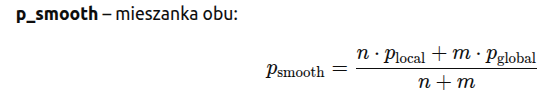

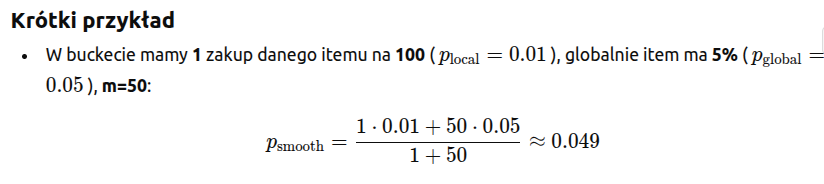

#### 1) lokalna popularność w buckecie

In [36]:
kot2["p_local"] = kot2["item_bucket_total"] / kot2["bucket_total"]
kot2["p_local"].head(5)

0    0.000000
1    0.000000
2    0.000000
3    0.011236
4    0.000000
Name: p_local, dtype: float64

#### 2) globalna popularność tych samochdoów

In [37]:
g = interactions.groupby("item_id")["label"].sum()
p_global = (g / g.sum()).rename("p_global").reset_index()
p_global.head(3)

,item_id,p_global
0,1,0.005814
1,2,0.005814
2,3,0.005814


Dzięki smoothingowi kolejność rekomendacji nie skacze w małych klasach dochodu gdzie dane są rzadkie. To stabilizuje ranking i zmniejsza ryzyko, że konsultant zobaczy „dziwne” hity oparte na 1–2 przypadkach.
Jak dobrać m ?
Startowo: m = 50 (działa sensownie w wielu przypadkach).
Prościej: ustaw m ≈ medianowa liczba zakupów per item w buckecie.
Lepsze: dostrój m pod metrykę (np. NDCG@5) na walidacji.

#### 3) smoothing priory globalne

In [27]:
m = 50  # możesz zmienić
pop = kot2.merge(p_global, on="item_id", how="left").fillna({"p_global": 0.0})
pop["p_smooth"] = (pop["item_bucket_total"]*pop["p_local"] + m*pop["p_global"]) / (pop["item_bucket_total"] + m)

#### porządek kolumn + podgląd

In [38]:
pop = pop[["klasy_dochodu","item_id","item_bucket_total","bucket_total","p_local","p_global","p_smooth"]]
pop.sort_values(["klasy_dochodu","p_smooth"], ascending=[True, False]).head(5)

,klasy_dochodu,item_id,item_bucket_total,bucket_total,p_local,p_global,p_smooth
62,"(2673.999, 7104.0]",86,3,89,0.033708,0.013566,0.014706
46,"(2673.999, 7104.0]",66,2,89,0.022472,0.013566,0.013908
70,"(2673.999, 7104.0]",98,2,89,0.022472,0.013566,0.013908
5,"(2673.999, 7104.0]",7,0,89,0.000000,0.013566,0.013566
61,"(2673.999, 7104.0]",85,1,89,0.011236,0.013566,0.013520


<div class="alert-info"; span style="font-size: 180% ">  Krok 6: Użycie: TOP-5 dla jednego klienta

In [29]:
df.head(3)

,customer_id,gender,age,education_level,business_type,monthly_income_pln,dependents,dwelling_type,residence_area,distance_to_city_km,...,previous_financing,previous_insurance,previous_purchase_price,previous_monthly_rate,previous_vehicle_age_at_purchase,current_budget_monthly_max,dti_limit,updated_at,klasy_dochodu,affordability_cap_pln
0,1,M,24,master,unemployed,31843,2,apartment,urban,0,...,NaN,NaN,NaN,NaN,NaN,8703.0,0.37,2025-09-18 05:56:25.242966,"(7104.0, 8802.0]",7953.00
1,2,M,62,master,public_sector,40000,0,house,rural,19,...,cash,OC_only,76469.0,0.00,0.0,11801.0,0.35,2025-10-29 05:56:25.242966,"(11741.5, 13984.0]",12862.75
2,3,M,56,bachelor,retired,40000,1,house,rural,48,...,lease_36,OC_AC,92528.0,82.14,3.0,11881.0,0.30,2025-08-16 05:56:25.242966,"(11741.5, 13984.0]",12862.75


<div class="alert-danger"> każdy klient jest tylko raz w bazie? 
    
ok trzeba opracować co będzie jak będzie kilka razy w bazie (wiele zakupów), ten algorytm może nie być na to gotowy.

In [30]:
df.customer_id.value_counts()

customer_id
1000    1
1       1
2       1
3       1
4       1
       ..
13      1
12      1
11      1
10      1
9       1
Name: count, Length: 1000, dtype: int64

In [31]:
cid = 449  # podaj ID klienta

cap   = float(df.loc[df.customer_id == cid, "affordability_cap_pln"].iloc[0])
buck  = df.loc[df.customer_id == cid, "klasy_dochodu"].iloc[0]

cand = items_df[items_df["monthly_rate_est"] <= cap].copy()                     # twardy filtr
cand = cand.merge(pop[pop["klasy_dochodu"] == buck][["item_id","p_smooth"]],    # popularność w buckecie
                  on="item_id", how="left").fillna({"p_smooth": 0.0})
top5 = cand.sort_values(["p_smooth","monthly_rate_est"], ascending=[False, True]).head(5)
top5

,Unnamed: 0,item_id,segment,model,trim,financing,price_est_pln,monthly_rate_est,p_smooth
85,85,86,compact,B3 Active,comfort,lease_36,99000.0,85.25,0.013566
84,84,85,compact,B3 Active,comfort,cash,99000.0,0.00,0.013525
6,6,7,city,A1 CityGo,comfort,lease_48,68750.0,42.97,0.013525
65,65,66,compact,B2 Hatch,base,lease_36,90000.0,77.50,0.013525
97,97,98,sedan,C1 Sedan,base,lease_36,120000.0,103.33,0.013525


<div class="alert-info"; span style="font-size: 180% ">  Krok 7: dashboard TOP-5 dla jednego klienta w call center

In [58]:
def top5(cid):  # podaj ID klienta

    cap   = float(df.loc[df.customer_id == cid, "affordability_cap_pln"].iloc[0])
    buck  = df.loc[df.customer_id == cid, "klasy_dochodu"].iloc[0]

    cand = items_df[items_df["monthly_rate_est"] <= cap].copy()                     # twardy filtr
    cand = cand.merge(pop[pop["klasy_dochodu"] == buck][["item_id","p_smooth"]],    # popularność w buckecie
                  on="item_id", how="left").fillna({"p_smooth": 0.0})
    top5 = cand.sort_values(["p_smooth","monthly_rate_est"], ascending=[False, True])[["segment","model","trim","financing","monthly_rate_est"]].reset_index().head(5)
    return top5

In [59]:
top5(969)

,index,segment,model,trim,financing,monthly_rate_est
0,97,sedan,C1 Sedan,base,lease_36,103.33
1,84,compact,B3 Active,comfort,cash,0.00
2,6,city,A1 CityGo,comfort,lease_48,42.97
3,65,compact,B2 Hatch,base,lease_36,77.50
4,85,compact,B3 Active,comfort,lease_36,85.25


## Gotowa aplikacja dla call center

In [60]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

cid_box = widgets.IntText(value=0, description='Klient ID:', disabled=False)
btn = widgets.Button(description="Pokaż TOP-5")

out_area = widgets.Output()

def on_click(_):
    out_area.clear_output()
    with out_area:
        try:
            df = top5(int(cid_box.value))   # <-- Twoja funkcja
            display(df)
        except Exception as e:
            print("Błąd:", e)

btn.on_click(on_click)
display(widgets.VBox([cid_box, btn, out_area]))